# Weapon impact

Correlation between main weapon used and various "features" of the round on different maps

In [1]:
from s2_analytics.filters import BALANCED
import sqlite3

import pandas as pd
import seaborn as sns

from s2_analytics.collector.sqlite_collector import SqliteCollector
from s2_analytics.constants import WEAPONS_PRIMARY, WEAPON_MODS_DATES
from s2_analytics.importer import import_games
from s2_analytics.main_weapon_analyzer import MainWeaponRoundTagger
from s2_analytics.team_round_tag_correlation_analyzer import TeamRoundTagCorrelationAnalyzer
from s2_analytics.test_summary_collector import SummaryCollector

conn = sqlite3.connect("file::memory:")
sqlite_collector = SqliteCollector(sqlite_conn=conn).init()
summary_collector = SummaryCollector(conn, sqlite_collector)
tag_correlation_analyzer = TeamRoundTagCorrelationAnalyzer(conn, sqlite_collector, [
    MainWeaponRoundTagger([WEAPONS_PRIMARY])]).init()
import_games(
    "logs_ranked/",
    start_date=WEAPON_MODS_DATES[0],
    processors=[tag_correlation_analyzer, sqlite_collector],
    game_filters=[
        lambda g: g.playlist_code == "CTF-Standard-6",
        BALANCED
    ]
)
pass

## Data summary

In [2]:
import tabulate

summary = summary_collector.get_summary().to_table()
tabulate.tabulate(summary, tablefmt='html')

First game,2022-12-28
Last game,2023-02-02
Games total,255
Rounds total,662
Games in playlist `CTF-Standard-6`,255


## Aggregated result

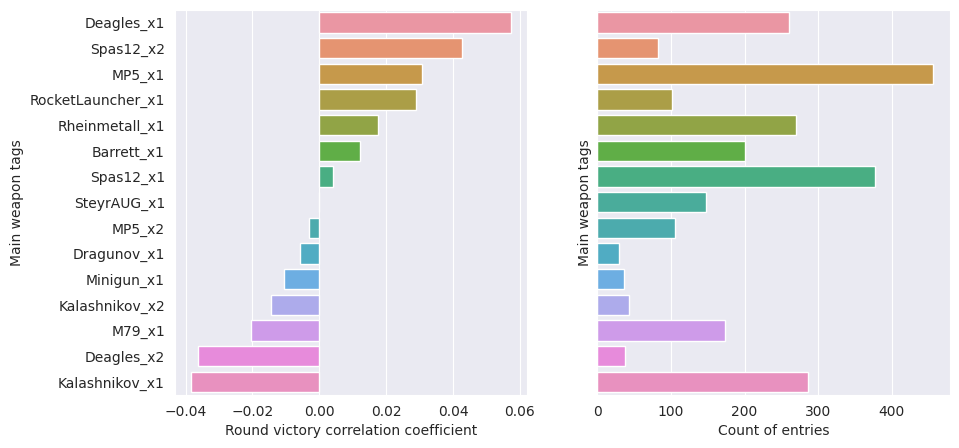

In [73]:
from matplotlib import pyplot as plt
from s2_analytics.test_main_weapon_analyzer import NO_RESULT_TAG_FILTER

correlation_per_map = tag_correlation_analyzer.calculate_win_correlation()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

corr = pd.DataFrame(correlation_per_map.items(), columns=["tag", "corr"])
counts = tag_correlation_analyzer.tag_counts(NO_RESULT_TAG_FILTER)
cnts = pd.DataFrame(counts.items(), columns=["tag", "cnt"]) \
    .sort_values(by=["cnt"], ascending=False) \
    .head(n=15)

merged = pd.merge(corr, cnts, on=["tag"]) \
    .sort_values(by=["corr"], ascending=False)
sns.barplot(x=merged["corr"], y=merged["tag"], ax=axes[0]).set(xlabel="Round victory correlation coefficient",
                                                               ylabel="Main weapon tags")
sns.barplot(x=merged["cnt"], y=merged["tag"], ax=axes[1]).set(xlabel="Count of entries", ylabel="Main weapon tags")
pass

## Each map separately

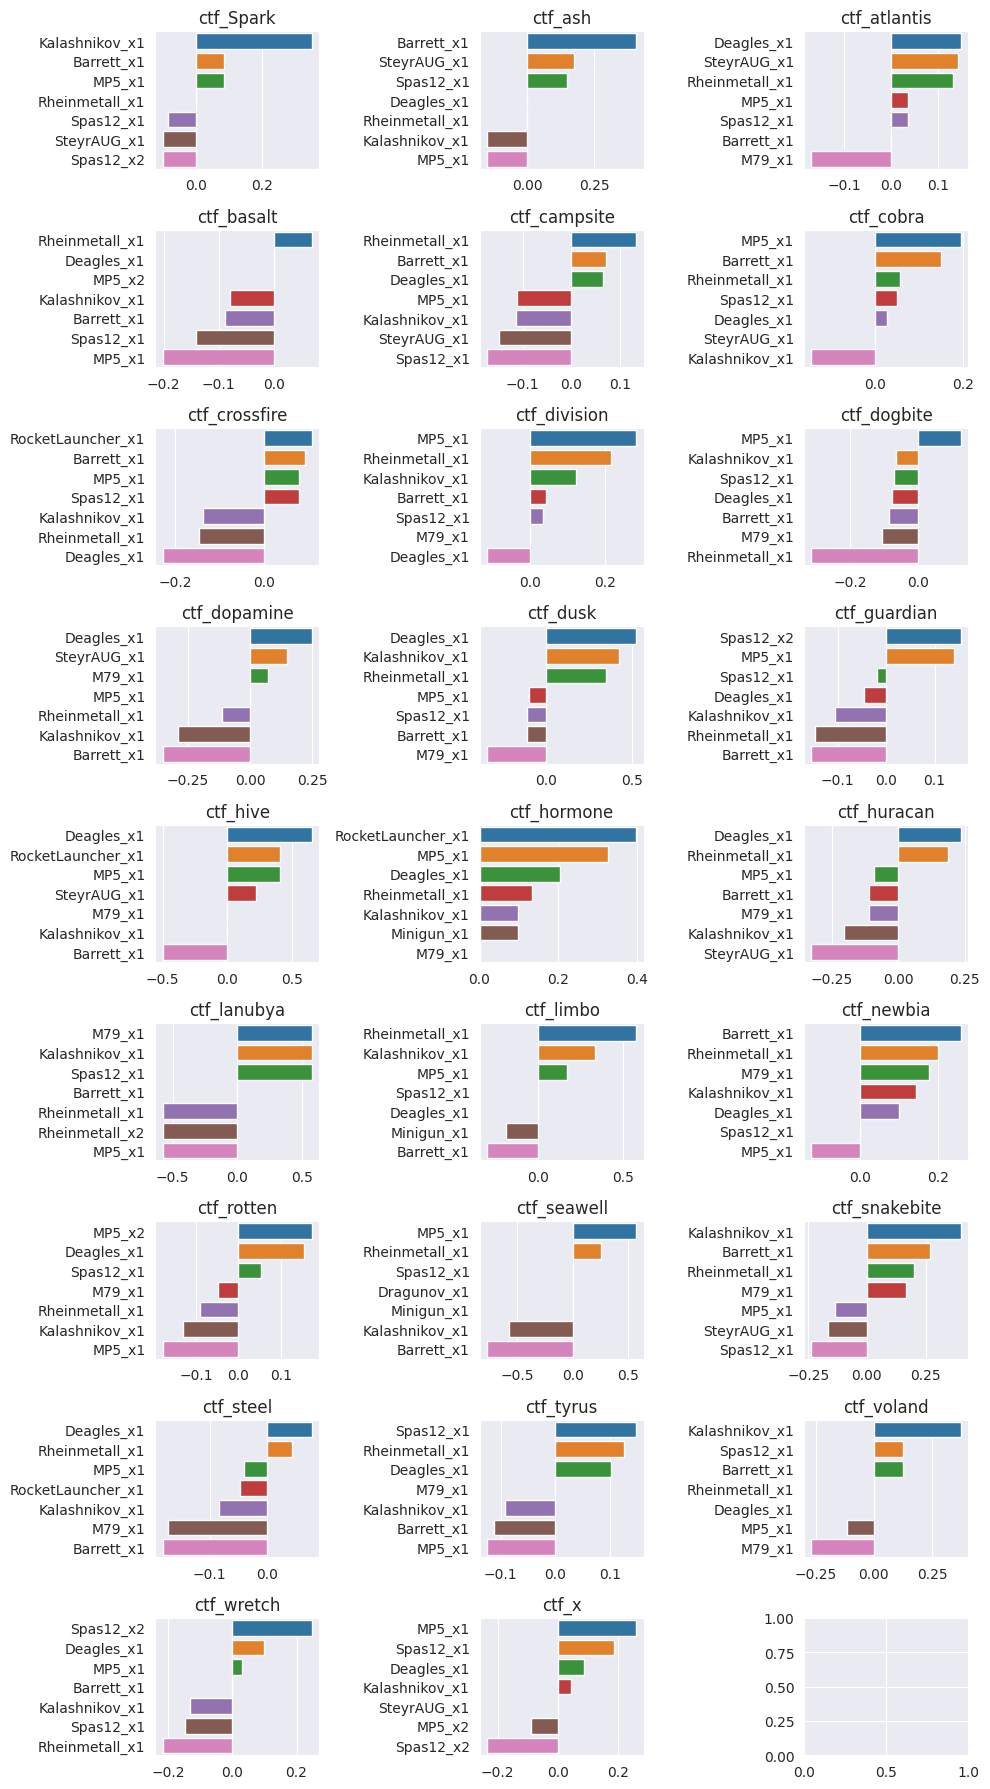

In [67]:
from math import ceil

correlation_per_map = tag_correlation_analyzer.calculate_win_correlation_per_map()
counts_per_map = tag_correlation_analyzer.tag_counts_per_map(NO_RESULT_TAG_FILTER)


def correlation_for_map(correlations, counts, map, axis):
    corr = pd.DataFrame(correlations.items(), columns=["tag", "corr"])
    cnts = pd.DataFrame(counts.items(), columns=["tag", "cnt"]) \
        .sort_values(by=["cnt"], ascending=False).head(n=7)
    merged = pd.merge(corr, cnts, on=["tag"]) \
        .sort_values(by=["corr"], ascending=False)
    sns.barplot(x=merged["corr"], y=merged["tag"], ax=axis).set(title=map, xlabel=None, ylabel=None)


nrows = ceil(len(counts_per_map.keys()) / 3)
fig, axes = plt.subplots(nrows, 3, figsize=(10, nrows * 2), tight_layout=True)
axes = axes.flatten()
for i, map in enumerate(sorted(list(counts_per_map.keys()))):
    axes[i].set(xlabel=None, ylabel=None)
    correlation_for_map(correlation_per_map[map], counts_per_map[map], map, axes[i])
pass